plot data in genome-wide

In [1]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### chromosome choices
#chr_choices = cell_chrnames['H1']
chr_choices = ['chr1']

In [7]:
### load gtab file
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_10kb_score.gtab.gz':
              {'H1_NCP_sp_8_1rep':(1, 'H1', 'NCP', 'sp', 8)},
              'H1_NCP_spd_1rep_10kb_score.gtab.gz':
              {'H1_NCP_spd_6_1rep':(1, 'H1', 'NCP', 'spd', 6)},
              'H1_NCP_CoH_1rep_10kb_score.gtab.gz':
              {'H1_NCP_CoH_5_1rep':(1, 'H1', 'NCP', 'CoH', 5)},
              'H1_NCP_PEG_1rep_10kb_score.gtab.gz':
              {'H1_NCP_PEG_6_1rep':(1, 'H1', 'NCP', 'PEG', 6)},
              'H1_NCP_Ca_1rep_10kb_score.gtab.gz':
              {'H1_NCP_Ca_5_1rep':(1, 'H1', 'NCP', 'Ca', 5)},
              'H1_NCP_HP1a_1rep_10kb_score.gtab.gz':
              {'H1_NCP_HP1a_3_1rep':(1, 'H1', 'NCP', 'HP1a', 3)},
              'H1_NCP_HP1bSUV_1rep_10kb_score.gtab.gz':
              {'H1_NCP_HP1bSUV_4_1rep':(1, 'H1', 'NCP', 'HP1bSUV', 4)}}

chr_dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                               data_path=gtab_path,
                                               chr_choices=chr_choices,
                                               by_chr_first=True)

loading H1_NCP_spd_1rep_10kb_score.gtab.gz


loading H1_NCP_sp_1rep_10kb_score.gtab.gz


loading H1_NCP_HP1a_1rep_10kb_score.gtab.gz


loading H1_NCP_PEG_1rep_10kb_score.gtab.gz


loading H1_NCP_HP1bSUV_1rep_10kb_score.gtab.gz


loading H1_NCP_CoH_1rep_10kb_score.gtab.gz


loading H1_NCP_Ca_1rep_10kb_score.gtab.gz


Done


In [8]:
### read G_banding file
gband_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/Gband/'
gband_fname = gband_path + 'Gband_human.txt'
chr_GID_Gband = load_file.read_Gband(gband_fname)

In [9]:
### read genome size
ref_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/ref_files/'
ref_fname = ref_path + '4D_hg38.fa'
genome_size = load_file.read_genome_size(ref_fname,
                                         chr_choices=chr_choices)

In [10]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
RNAseq_fname = 'ENCFF174OMR.tsv'
geneID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)

In [11]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/GTF/'
GTF_fname = 'ENCFF159KBI.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=chr_choices)

In [12]:
### read HiC eigenvector file
eigen_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/HiC/'
eigen_fname = 'eigen_H1_100kb.bedgraph'
chr_eID_value = load_file.read_bedgraph (eigen_path + eigen_fname,
                                         chr_choices=chr_choices,
                                         by_chr=True)

In [13]:
### figure parameters
# set figure binning parameters
i = 20
bin_size = int(0.5*(10**6) / i) # binsize (unit of bp)
bin_step = bin_size # no overlap
blur_win = int(4*i + 1) # sliding window (unit of bin)

In [14]:
### binning/smooting the condense-seq data
chr_dkey_sig = {}
for chr in chr_dkey_ID_value:
    for dkey in chr_dkey_ID_value[chr]:
        ID_value = chr_dkey_ID_value[chr][dkey]
        ID_loc = {ID:ID[1:] for ID in ID_value}
        max_pos = genome_size[chr]

        binID_mean = statis.rbin_data_mean(bin_size,
                                           bin_step,
                                           ID_loc,
                                           ID_value,
                                           max_pos=max_pos,
                                           silent=True)

        sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
        sig = statis.slow_moving_average2(sig, blur_win)

        if chr not in chr_dkey_sig:
            chr_dkey_sig[chr] = {}
        chr_dkey_sig[chr][dkey] = sig


In [15]:
### rescale/reorganize the RNA-seq data
chr_geneID_pos = {}
chr_geneID_logFPKM = {}
min_FPKM = min(geneID_FPKM.values())
for geneID in geneID_FPKM:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue

    if chr not in chr_geneID_pos:
        chr_geneID_pos[chr] = {}
    chr_geneID_pos[chr][geneID] = pos

    logFPKM = np.log2(geneID_FPKM[geneID] - min_FPKM + 1)
    if chr not in chr_geneID_logFPKM:
        chr_geneID_logFPKM[chr] = {}
    chr_geneID_logFPKM[chr][geneID] = logFPKM
    

In [16]:
### binning/smoothing the RNA-seq data
chr_RNA_sig = {}
for chr in chr_choices:
    geneID_pos = chr_geneID_pos[chr]
    geneID_logFPKM = chr_geneID_logFPKM[chr]
    max_pos = genome_size[chr]
    binID_mean = statis.rbin_data_mean(bin_size,
                                       bin_step,
                                       geneID_pos,
                                       geneID_logFPKM,
                                       max_pos=max_pos,
                                       silent=True)
    
    sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
    sig = statis.slow_moving_average2(sig, blur_win)
    chr_RNA_sig[chr] = sig


In [17]:
### binning/smoothing the eigenvector data
chr_eigen_sig = {}
for chr in chr_choices:
    eID_value = chr_eID_value[chr]
    eID_loc = {eID:eID[1:] for eID in eID_value}
    max_pos = genome_size[chr]

    binID_mean = statis.rbin_data_mean(bin_size,
                                       bin_step,
                                       eID_loc,
                                       eID_value,
                                       max_pos=max_pos,
                                       silent=True)

    sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
    sig = statis.slow_moving_average2(sig, int(4*i/5.0 + 1))

    if chr not in chr_eigen_sig:
        chr_eigen_sig[chr] = {}
    chr_eigen_sig[chr] = sig
    

In [18]:
### binning the G-banding data
chr_binID_GID = {}
chr_GID_binwin = {}
for chr in chr_choices:
    GID_Gband = chr_GID_Gband[chr]

    Int_dict_Gband = Interval_dict.bin_hash(bin_size,
                                            bin_step,
                                            genome_size[chr],
                                            silent=True)
    
    binID_GIDs = {}
    for GID in GID_Gband:
        st, ed = GID_Gband[GID]['interval']
        find_binIDs = Int_dict_Gband.insert_range(st, ed, 1)
        binID_value = Int_dict_Gband.get()
        for binID in find_binIDs:
            if binID not in binID_GIDs:
                binID_GIDs[binID] = []
            binID_GIDs[binID].append((binID_value[binID], GID))
        Int_dict_Gband.clear()

    binID_GID = {}
    GID_binIDs = {}
    for binID, GIDs in binID_GIDs.items():
        GID = sorted(GIDs, reverse=True)[0][1]
        binID_GID[binID] = GID
        if GID not in GID_binIDs:
            GID_binIDs[GID] = []
        GID_binIDs[GID].append(binID)

    GID_binwin = {}
    for GID, binIDs in GID_binIDs.items():
        GID_binwin[GID] = (min(binIDs), max(binIDs))
            
    chr_binID_GID[chr] = binID_GID
    chr_GID_binwin[chr] = GID_binwin

    del Int_dict_Gband, binID_GIDs, GID_binIDs


In [19]:
### make ideogram
chr_Gtype_ideogram = {}
for chr in chr_choices:
    GID_Gband = chr_GID_Gband[chr]
    Gtype_ideogram = {'num':[], 'var':[], 'acen':[]}
    binID_st, binID_ed = 0, genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed + 1):
        try:
            GID = chr_binID_GID[chr][binID]
            Gtype = GID_Gband[GID]['type']
            Gvalue = GID_Gband[GID]['value']
        except:
            for key in Gtype_ideogram:
                Gtype_ideogram[key].append([np.nan])
            continue

        if Gtype in ['neg', 'pos']:
            Gtype = 'num'
            assert not np.isnan(Gvalue)
        elif Gtype in ['var', 'acen']:
            Gvalue = 10
        else:
            pass
            
        for key in Gtype_ideogram:
            if key == Gtype:
                Gtype_ideogram[key].append([Gvalue])
            else:
                Gtype_ideogram[key].append([np.nan])

    chr_Gtype_ideogram[chr] = Gtype_ideogram

In [20]:
### set xtick labels along chromosome
chr_xtick_locs = {}
chr_xtick_labels = {}
for chr in chr_choices:
    xtick_locs, xtick_labels = [], []

    binID_st = 0
    binID_ed = genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed+1):
        pos = bin_step*binID + bin_size/2
        Mb_pos = int(round(float(pos)/(10**6)))

        if Mb_pos % 10 !=0: # 10Mbp steps
            continue

        label = str(Mb_pos)
        if label not in xtick_labels:
            xtick_locs.append(binID)
            xtick_labels.append(label)

    chr_xtick_locs[chr] = xtick_locs
    chr_xtick_labels[chr] = xtick_labels

In [21]:
### set xtick labels for ideogram
chr_Gtick_locs = {}
chr_Gtick_labels = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    Gtick_locs, Gtick_labels = [], []
    for GID in sorted(GID_binwin.keys()):
        binID_st, binID_ed = GID_binwin[GID]
        pos = (binID_st + binID_ed)/2
        Gname = chr_GID_Gband[chr][GID]['name']
        Gtick_locs.append(pos)
        Gtick_labels.append(Gname)
    chr_Gtick_locs[chr] = Gtick_locs
    chr_Gtick_labels[chr] = Gtick_labels

In [22]:
### set heterochromatin regions of ideogram
chr_shade_wins = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    shade_wins = []
    for GID in sorted(GID_binwin.keys()):
        Gtype = chr_GID_Gband[chr][GID]['type']
        if Gtype =='pos':
            shade_wins.append(GID_binwin[GID])
    chr_shade_wins[chr] = shade_wins


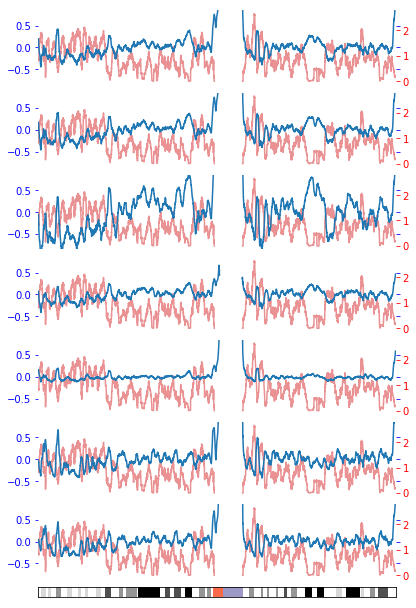

In [27]:
### plot genome-wide data along with ideogram
## figure parameters
side_names_list = [{'left':[(1, 'H1', 'NCP', 'sp', 8)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'spd', 6)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'CoH', 5)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'PEG', 6)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'Ca', 5)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'HP1a', 3)],
                    'right':['RNA']},
                   {'left':[(1, 'H1', 'NCP', 'HP1bSUV', 4)],
                    'right':['RNA']}
                   ]

name_color = {(1, 'H1', 'NCP', 'sp', 8):'tab:blue',
              (1, 'H1', 'NCP', 'spd', 6):'tab:blue',
              (1, 'H1', 'NCP', 'CoH', 5):'tab:blue',
              (1, 'H1', 'NCP', 'PEG', 6):'tab:blue',
              (1, 'H1', 'NCP', 'Ca', 5):'tab:blue',
              (1, 'H1', 'NCP', 'HP1a', 3):'tab:blue',
              (1, 'H1', 'NCP', 'HP1bSUV', 4):'tab:blue',
              'RNA':'tab:red'}

name_alpha = {'RNA':0.5}
side_ylabel_list = [{'left':'', 'right':''}] * len(side_names_list)
side_ycolor_list = [{'left':'blue', 'right':'red'}] * len(side_names_list)
side_ylim_list =[{'left':[-0.85, 0.85], 'right':None}] * len(side_names_list)


## plot data in genome-wide (condensability vs gene expression)
for chr in chr_choices:
    name_sig = {}
    for dkey, sig in chr_dkey_sig[chr].items():
        name_sig[dkey] = statis.standardize (sig, by_std=False)
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    axes = graphics.plot_genome_wide_multiple (side_names_list,
                                               name_sig,
                                               name_color=name_color,
                                               name_alpha=name_alpha,
                                               side_ylabel_list=side_ylabel_list,
                                               side_ycolor_list=side_ycolor_list,
                                               side_ylim_list=side_ylim_list,
                                               xtick_locs=chr_xtick_locs[chr],
                                               xtick_labels=chr_xtick_labels[chr],
                                               Gtype_ideogram=chr_Gtype_ideogram[chr],
                                               Gtick_locs=chr_Gtick_locs[chr],
                                               Gtick_labels=chr_Gtick_labels[chr],
                                               shade_wins=None,
                                               xlabel='',
                                               save=False)
